In [1]:
import pandas as pd
import numpy as np
from pandas import read_excel
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics

#Prophet modelling and metric tools
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Importing plotly failed. Interactive plots will not work.


Resources
https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66 ; 
https://mode.com/example-gallery/forecasting_prophet_python_cookbook/ ;
https://github.com/raffg/prophet_forecasting/blob/master/prophet.ipynb ; https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors

In [2]:
#vol = read_excel('spx_data_1971to2020331.xlsx', sheet_name = 'Data', header = 0, index_col = 0, squeeze = True)
vol = pd.read_csv('spx_data_1971to2020331.csv')
print(vol)

             Date  AVG_VOL
0      1970/12/31    0.484
1        1971/1/4    0.326
2        1971/1/5    0.344
3        1971/1/6    0.266
4        1971/1/7    0.308
...           ...      ...
12417   2020/3/24   79.716
12418   2020/3/25   74.070
12419   2020/3/26   43.168
12420   2020/3/27   25.448
12421   2020/3/30    8.412

[12422 rows x 2 columns]


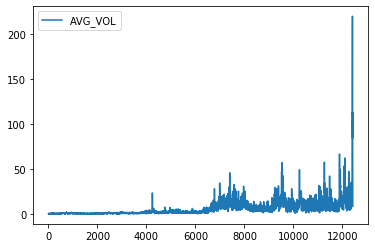

In [3]:
#vol.index = pd.DatetimeIndex(vol.index).to_period('D')
vol.plot()
plt.show()

0       -1.177817e-01
1       -1.180251e-01
2       -1.180200e-01
3       -1.180324e-01
4       -1.180285e-01
             ...     
12418    8.163398e+14
12419    8.420173e+12
12420    9.569644e+10
12421    8.088710e+06
12422             NaN
Name: boxcox_y, Length: 12423, dtype: float64


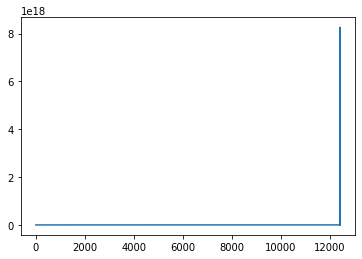

In [27]:
#Do the boxcox transformation using automated optimised lamda
from scipy.stats import boxcox
vol['boxcox_y'], lamda = boxcox(vol['AVG_VOL'])

print(vol['boxcox_y'])
vol['boxcox_y'].plot()
plt.show()

In [4]:
#Data preparation by creating a new data frame consisting of date and original value of AVG_VOL
df = pd.DataFrame()
df['ds'] = pd.to_datetime(vol['Date'])
df['y'] = vol['AVG_VOL']
#print(df)

#To identify missing vlaue and ensure to remove them all.
df.dropna(axis = 0, how = 'any', inplace = True)
print(df.isnull().any().sum()) #The number of missing values

0


# Model Implementation

In [5]:
#Define the model with a daily seasonality
model = Prophet(daily_seasonality = True)
model.fit(df) 
future = model.make_future_dataframe(periods = 365, freq = 'D')

#Make the out-sample forecast/prediction
fcast = model.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
#print(fcast)
#print(fcast.max())
#print(fcast.min())

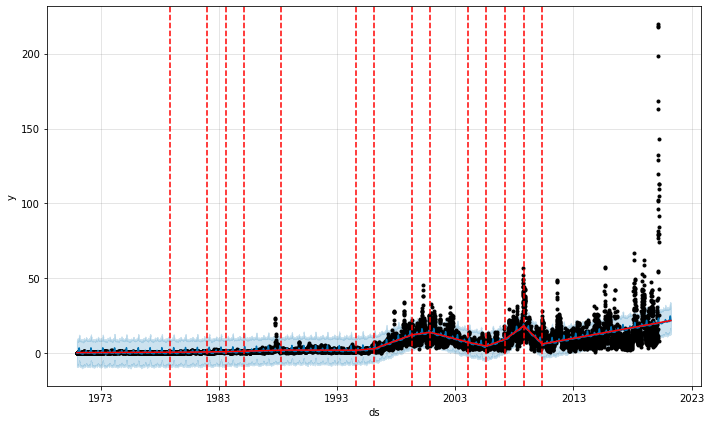

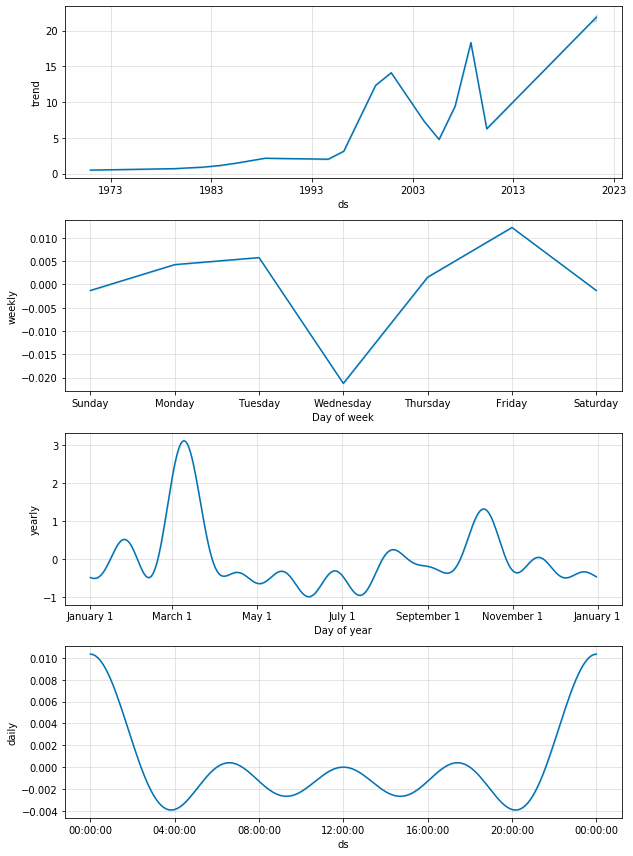

In [6]:
#Plot the fitted and forecasting results and turning points where the trends changed.
#Red dash lines indicate the turning points where the trends changed.
#Resources: https://facebook.github.io/prophet/docs/quick_start.html

fig = model.plot(fcast)
a = add_changepoints_to_plot(fig.gca(), model, fcast)
pyplot.show()

component = model.plot_components(fcast)
pyplot.show()

In [7]:
# Check when the turning points occurred
m_change = model.changepoints
print('The date to turning points')
print(m_change)
print('How many turning points?', len(m_change))

The date to turning points
397    1972-07-26
795    1974-02-26
1192   1975-09-22
1590   1977-04-19
1987   1978-11-13
2385   1980-06-11
2782   1982-01-07
3180   1983-08-03
3577   1985-02-27
3974   1986-09-23
4372   1988-04-20
4769   1989-11-13
5167   1991-06-12
5564   1993-01-06
5962   1994-08-03
6359   1996-02-28
6756   1997-09-23
7154   1999-04-23
7551   2000-11-15
7949   2002-06-24
8346   2004-01-21
8744   2005-08-18
9141   2007-03-20
9539   2008-10-15
9936   2010-05-14
Name: ds, dtype: datetime64[ns]
How many turning points? 25


# Try to choose/tune some parameters

In [8]:
### Tuning parameters based on trends
#Define the model, with new adjusted parameters and regressors on new variable.
model_trend = Prophet(growth = 'linear', 
                n_changepoints = 25,
                changepoint_prior_scale = 0.1, #Adjust how the model fit in with change points to adjust the "trend" component.
                #Default = 0.05, larger, more flexible. 10 to 25 works fine practically.
                yearly_seasonality = False,
                weekly_seasonality = False,
                daily_seasonality = False) #Try commit no seasonality component

#Fit the model onto the original dataset.
model_trend.fit(df)
future1 = model_trend.make_future_dataframe(periods = 365, freq = 'D')

#Make the out-sample forecast/prediction: future 365 days
fcast1 = model_trend.predict(future1)

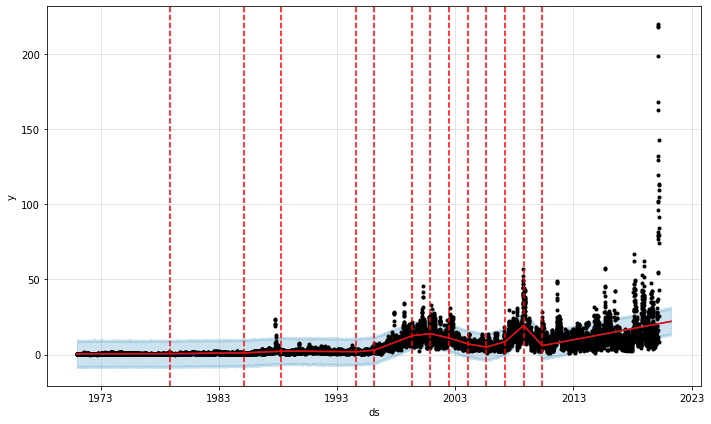

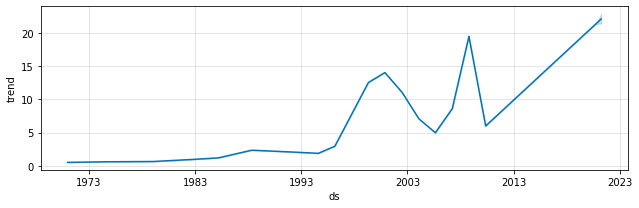

In [10]:
#Plot the fitted and forecasting results and turning points where the trends changed.
#Red dash lines indicate the turning points where the trends changed.
#Resources: https://facebook.github.io/prophet/docs/quick_start.html

fig1 = model_trend.plot(fcast1)
a1 = add_changepoints_to_plot(fig1.gca(), model_trend, fcast1)
pyplot.show()

component1 = model_trend.plot_components(fcast1)
pyplot.show()

m_change1 = model_trend.changepoints
#print(m_change)
#print(len(m_change))

# Tuning the parameters based on seasonality

In [12]:
### Tuning the parameters based on seasonality.
#Define the model, with new adjusted parameters and regressors on new variable.
model_seas = Prophet(growth = 'linear', 
                n_changepoints = 25,
                changepoint_prior_scale = 15, #Can adjust how the model fit in with change points 
                #Default = 0.05, larger, flexible. 10 to 25 works fine practically.
                yearly_seasonality = False,
                weekly_seasonality = False,
                daily_seasonality = True) #Commit a daily seasonality

#Add yearly and weekly seasonalities using fourier order to determine flexibility/impact
model_seas.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 15)
model_seas.add_seasonality(name = 'weeky', period = 1, fourier_order = 20) 
# larger fourier_order determines larger flexibility
# fourier_order ranging between 10-20 works better.

#Fit the data
model_seas.fit(df)

# Make out-sample forecasting
future2 = model_seas.make_future_dataframe(periods = 1500, freq = 'D') #Predict out-sample/future 1500 days results.
fcast2 = model_seas.predict(future2) #Conduct the out-sample prediction.

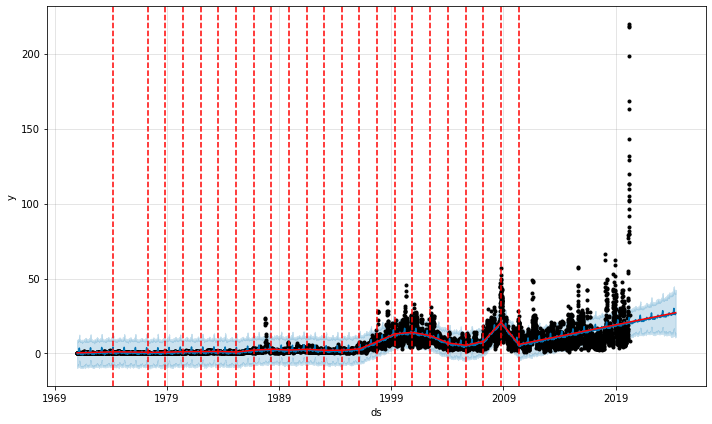

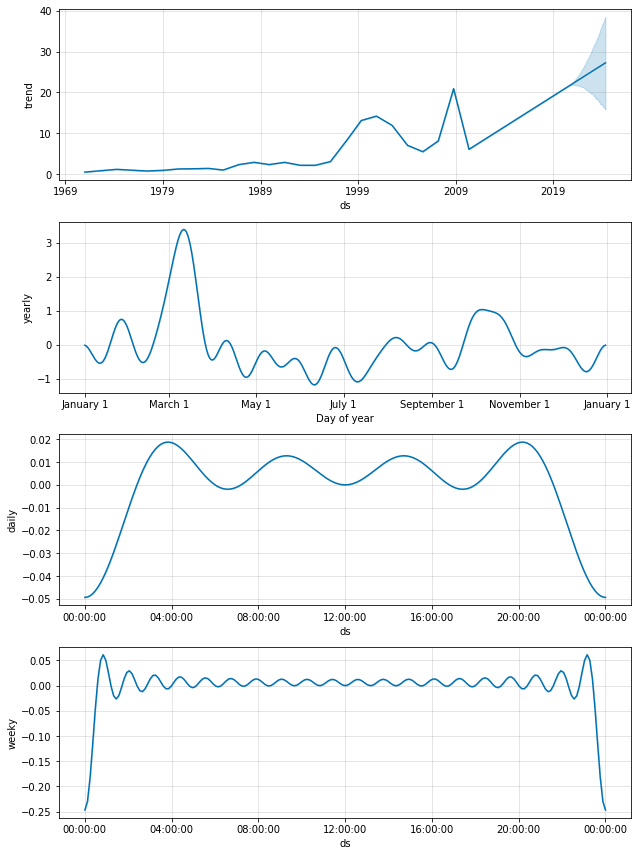

In [13]:
#Plot the fitted and forecasting results and turning points where the trends changed.
#Red dash lines indicate the turning points where the trends changed.
#Resources: https://facebook.github.io/prophet/docs/quick_start.html

fig2 = model_seas.plot(fcast2)

a2 = add_changepoints_to_plot(fig2.gca(), model_seas, fcast2)
pyplot.show()

component2 = model_seas.plot_components(fcast2)
pyplot.show()


#m_change2 = model_seas.changepoints
#print(m_change)
#print(len(m_change))

# Check forecasting results (in- and out-sample)

In [14]:
print(type(fcast2))
print(fcast2)

<class 'pandas.core.frame.DataFrame'>
              ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0     1970-12-31   0.469741   -8.799641    8.616497     0.469741     0.469741   
1     1971-01-04   0.472118   -8.764334    9.071890     0.472118     0.472118   
2     1971-01-05   0.472712   -8.238597    8.709413     0.472712     0.472712   
3     1971-01-06   0.473307   -9.658924    9.017841     0.473307     0.473307   
4     1971-01-07   0.473901   -8.724915    8.373054     0.473901     0.473901   
...          ...        ...         ...         ...          ...          ...   
13917 2024-05-04  27.206082   12.021317   42.190401    15.821341    38.438689   
13918 2024-05-05  27.210227   12.092021   41.274799    15.815243    38.455213   
13919 2024-05-06  27.214373   13.311317   42.408167    15.809146    38.471123   
13920 2024-05-07  27.218518   12.919935   40.797673    15.803048    38.487034   
13921 2024-05-08  27.222663   13.170746   40.867739    15.796950    38.

In [15]:
from matplotlib import pyplot as plt
from datetime import datetime
import time
fcast_part = fcast2[fcast2['ds'] > '2019-01-01']
fcast_part

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weeky,weeky_lower,weeky_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
12109,2019-01-02,19.126904,9.991160,27.499340,19.126904,19.126904,-0.321013,-0.321013,-0.321013,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.024812,-0.024812,-0.024812,0.0,0.0,0.0,18.805890
12110,2019-01-03,19.131049,9.755031,27.146867,19.131049,19.131049,-0.354458,-0.354458,-0.354458,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.058257,-0.058257,-0.058257,0.0,0.0,0.0,18.776591
12111,2019-01-04,19.135194,9.852427,27.018790,19.135194,19.135194,-0.404026,-0.404026,-0.404026,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.107824,-0.107824,-0.107824,0.0,0.0,0.0,18.731169
12112,2019-01-07,19.147630,9.728680,26.970519,19.147630,19.147630,-0.609783,-0.609783,-0.609783,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.313582,-0.313582,-0.313582,0.0,0.0,0.0,18.537847
12113,2019-01-08,19.151775,9.316098,26.984573,19.151775,19.151775,-0.680813,-0.680813,-0.680813,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.384611,-0.384611,-0.384611,0.0,0.0,0.0,18.470963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13917,2024-05-04,27.206082,12.021317,42.190401,15.821341,38.438689,-0.537070,-0.537070,-0.537070,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.240869,-0.240869,-0.240869,0.0,0.0,0.0,26.669012
13918,2024-05-05,27.210227,12.092021,41.274799,15.815243,38.455213,-0.498170,-0.498170,-0.498170,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.201968,-0.201968,-0.201968,0.0,0.0,0.0,26.712058
13919,2024-05-06,27.214373,13.311317,42.408167,15.809146,38.471123,-0.479191,-0.479191,-0.479191,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.182989,-0.182989,-0.182989,0.0,0.0,0.0,26.735182
13920,2024-05-07,27.218518,12.919935,40.797673,15.803048,38.487034,-0.480195,-0.480195,-0.480195,-0.049367,...,-0.246835,-0.246835,-0.246835,-0.183994,-0.183994,-0.183994,0.0,0.0,0.0,26.738323


In [16]:
date = fcast_part['ds']
value = fcast_part['yhat']
print(date)
type(date.iloc[0]) #.timestamp()

12109   2019-01-02
12110   2019-01-03
12111   2019-01-04
12112   2019-01-07
12113   2019-01-08
           ...    
13917   2024-05-04
13918   2024-05-05
13919   2024-05-06
13920   2024-05-07
13921   2024-05-08
Name: ds, Length: 1813, dtype: datetime64[ns]


pandas._libs.tslibs.timestamps.Timestamp

In [17]:
print(date.iloc[0])
print(type(date.iloc[0].date()))

2019-01-02 00:00:00
<class 'datetime.date'>


In [18]:
type(value.iloc[0])

numpy.float64

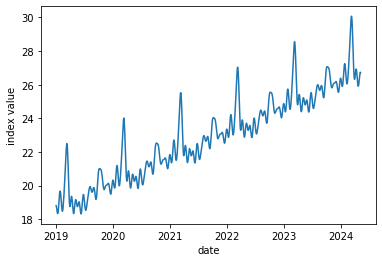

In [19]:
# Grab the specific period to plot, by which we can observe its details
date = fcast_part['ds']
value = fcast_part['yhat']
date_lst = []
value_lst = []
for i in range(len(value)):
    #When plotting, the time in x-axis must be datetime type, not string or timestamps.
    date_lst.append(date.iloc[i].date())
    value_lst.append(value.iloc[i])

plt.plot(date_lst, value_lst)
plt.xlabel('date')
plt.ylabel('index value')
plt.show()

# Adding additional regressors to do in-sample forecast

"The extra regressor must be known for both the history and for future dates. It thus must either be something that has known future values (such as nfl_sunday), or something that has separately been forecasted elsewhere."
For this reason, INDU, which we will add as regressor as following, will not be an appropriate regressor used for out-sample forecasting (predict future) because it's value is not known for futured dates. We make this demo by purely showing how INDU can impact or improve model's in-sample performance as a regressor that is not know for future dates.

In [20]:
### Tuning the model by additional regressors and parameters adjustment.
#Load new data---INDU index
indu = pd.read_csv('INDU_daily_1970-20200331.csv')
print(indu.isnull().any().sum())

#To identify missing vlaue and ensure to remove them all.
indu.dropna(axis = 0, how = 'any', inplace = True)
print(indu.isnull().any().sum()) #The number of missing values

print('Indu data')
print(indu)
print('--------------------------------------------')
print('df data')
print(df)
print('--------------------------------------------')
print('Is the length of indu and df (original training dataframe the same??', len(indu) == len(df))

0
0
Indu data
             Date      INDU
0      1970/12/31    838.92
1        1971/1/4    830.57
2        1971/1/5    835.77
3        1971/1/6    837.97
4        1971/1/7    837.83
...           ...       ...
12430   2020/3/25  21200.55
12431   2020/3/26  22552.17
12432   2020/3/27  21636.78
12433   2020/3/30  22327.48
12434   2020/3/31  21917.16

[12435 rows x 2 columns]
--------------------------------------------
df data
              ds       y
0     1970-12-31   0.484
1     1971-01-04   0.326
2     1971-01-05   0.344
3     1971-01-06   0.266
4     1971-01-07   0.308
...          ...     ...
12417 2020-03-24  79.716
12418 2020-03-25  74.070
12419 2020-03-26  43.168
12420 2020-03-27  25.448
12421 2020-03-30   8.412

[12422 rows x 2 columns]
--------------------------------------------
Is the length of indu and df (original training dataframe the same?? False


In [21]:
#Load, again, the avg_vol data of SPX index (df) to a new data frame df2 to manipulate (same as have done in previous section).
df2 = pd.DataFrame()
df2['ds'] = pd.to_datetime(vol['Date'])
df2['y'] = vol['AVG_VOL']
#print(df)

#Include indu index to the original df, making df2
df2['indu'] = indu['INDU']

#Check missing value in new dataframe for feeding the model, df
print(df2.isnull().any().sum()) #Find 2 missing values
df2.dropna(axis = 0, how = 'any', inplace = True)
print(df2['indu'].isnull().any().sum()) #Final amount of missing value in df
print(df2)

#Split the dataset into training/test set by assigning an interval of time period
df_train = df2[df2['ds'] < pd.to_datetime('2018')]
df_test = df2[df2['ds'] > pd.to_datetime('2018')]
print('length of df_train:', len(df_train))
print('length of df_test:', len(df_test))

0
0
              ds       y      indu
0     1970-12-31   0.484    838.92
1     1971-01-04   0.326    830.57
2     1971-01-05   0.344    835.77
3     1971-01-06   0.266    837.97
4     1971-01-07   0.308    837.83
...          ...     ...       ...
12417 2020-03-24  79.716  25864.78
12418 2020-03-25  74.070  23851.02
12419 2020-03-26  43.168  25018.16
12420 2020-03-27  25.448  23553.22
12421 2020-03-30   8.412  21200.62

[12422 rows x 3 columns]
length of df_train: 11858
length of df_test: 564


In [22]:
#### Build the model with default and Add regressor
pro_regressor = Prophet()
pro_regressor.add_regressor('indu')

#Fit the data
pro_regressor.fit(df_train) #df_train
#future_regress = pro_regressor.make_future_dataframe(periods = 564, freq = 'D')

# in-sample forecast over test-set data
fcast_regress = pro_regressor.predict(df_test) #df_test

#pro_regressor.plot(fcast_regress)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
#Check the value for results of in-sample prediction --- .predict(df_test)
print(fcast_regress['yhat'])
yhat = fcast_regress['yhat']
#print(len(yhat))

#MSE
from sklearn import metrics
MSE = metrics.mean_squared_error(df_test['y'], yhat)
print('The MSE for model "pro_gressor" = ', MSE)

#MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(np.array(df_test['y']), np.array(yhat))
print('The MAPE for model "pro_gressor" = ', mape)

0      10.056218
1      10.032562
2      10.105973
3      10.206726
4      10.305773
         ...    
559     8.537285
560     7.879204
561     8.239485
562     7.817698
563     7.147495
Name: yhat, Length: 564, dtype: float64
The MSE for model "pro_gressor" =  860.2097529671145
The MAPE for model "pro_gressor" =  44.33920655981042


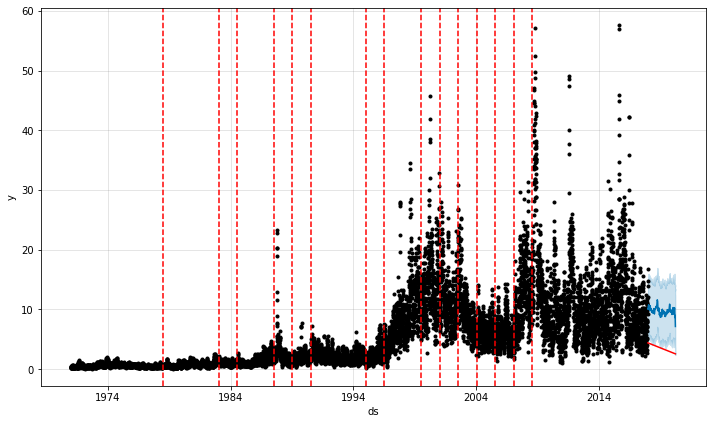

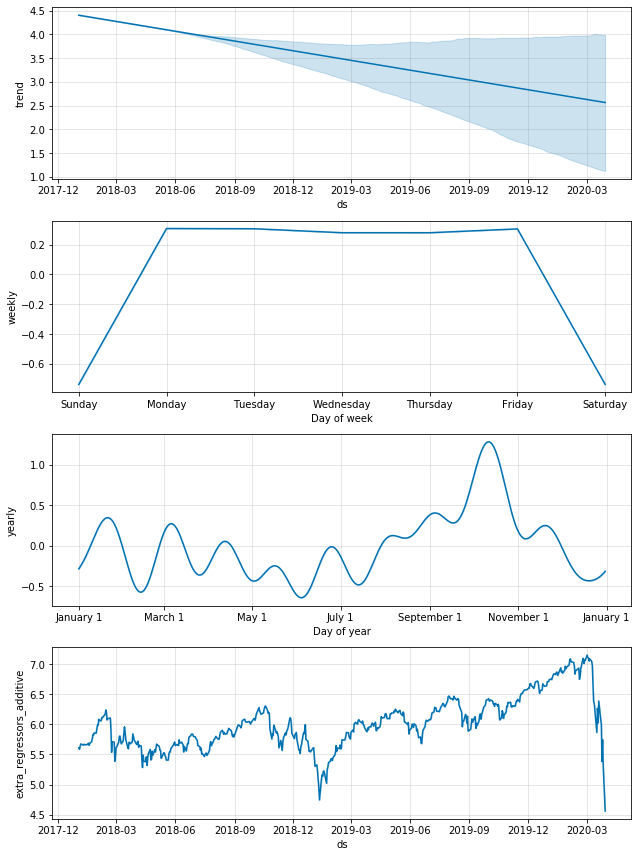

In [25]:
#Plot the "in-sample" forecasting results, alongside turning points where the trends changed.
#Red dash lines indicate the turning points where the trends changed.
#Resources: https://facebook.github.io/prophet/docs/quick_start.html

fig_regress = pro_regressor.plot(fcast_regress)
a_regress = add_changepoints_to_plot(fig_regress.gca(), pro_regressor, fcast_regress)
pyplot.show()

component_regress = pro_regressor.plot_components(fcast_regress)
pyplot.show()

m_change_regress = pro_regressor.changepoints
#print(m_change)
#print(len(m_change))

In [26]:
#print(fcast_regress)

#Obtain metrics, MAPE, MSE and MAE for measuring model's in-sample performance.
import numpy as np
from sklearn import metrics

def mape(true, pred):
    return np.mean(np.abs((true - pred) / true)) * 100


def errors(true, pred):
    MSE = metrics.mean_squared_error(true, pred)
    MAE = metrics.mean_absolute_error(true, pred)
    MAPE = mean_absolute_percentage_error(true, pred)
    return MSE, MAE, MAPE

print(type(fcast_regress['yhat']))
print(fcast_regress['yhat'])
print(type(df_test['y']))
print(df_test['y']) #Particularly select y column and ignore 'indu' which we add in this data frame before regressor is built.

print('MSE, MAE and MAPE of Pure Regressor Prophet Model are {0}'.format(errors(df_test['y'], fcast_regress['yhat'])))

<class 'pandas.core.series.Series'>
0      10.056218
1      10.032562
2      10.105973
3      10.206726
4      10.305773
         ...    
559     8.537285
560     7.879204
561     8.239485
562     7.817698
563     7.147495
Name: yhat, Length: 564, dtype: float64
<class 'pandas.core.series.Series'>
11858    11.096
11859     8.258
11860     9.938
11861     9.842
11862    10.894
          ...  
12417    79.716
12418    74.070
12419    43.168
12420    25.448
12421     8.412
Name: y, Length: 564, dtype: float64
MSE, MAE and MAPE of Pure Regressor Prophet Model are (860.2097529671145, 14.213159120549463, nan)


# Model with additional regressor, seasonalities and holidays --- out-sample forecasting

In this case, the below extra regressor, wed, can be applied for out-sample forecasting. We can always know and expect which future dates will come to be Wednesday and be labelled as series "wed". In this case, we only deploy the regressor to demonstrate out-sample scenario.  

Notice again that we don't apply df2 (dataframe with INDU index) here, as length of INDU index is not as lengthy as forecasting future dataframe which has 365 days more in this case (datetime msitached!!) Therefore we cannot forecast SPX_VOL with it taken into account.

In [27]:
#Define a function of "ds" which we apply to generate new set of values supporting Prophet forecasting.
#We want to stress the importance of presence of Wednesday that may impact SPX Volatility.
def wed_func(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 2: # 2 for Wednesday as Python is indexed starting with 0 (for Monday)
        return 1
    else:
        return 0
df3 = df.copy()
df3['wed'] = df['ds'].apply(wed_func)
print(df3)

              ds       y  wed
0     1970-12-31   0.484    0
1     1971-01-04   0.326    0
2     1971-01-05   0.344    0
3     1971-01-06   0.266    1
4     1971-01-07   0.308    0
...          ...     ...  ...
12417 2020-03-24  79.716    0
12418 2020-03-25  74.070    1
12419 2020-03-26  43.168    0
12420 2020-03-27  25.448    0
12421 2020-03-30   8.412    0

[12422 rows x 3 columns]


In [28]:
#Define the model, with US hoildays and regressors.
model = Prophet(growth = 'linear', 
                yearly_seasonality = True,
                weekly_seasonality = True,
                daily_seasonality = True,
                seasonality_mode = 'multiplicative')
model.add_country_holidays(country_name = 'US') # Add holiday
model.add_regressor('wed')

#Fit the model above to full set of data.
model.fit(df3) 
future = model.make_future_dataframe(periods = 365, freq = 'D')
###It is key: apply Wednesday function to future dataframe to generate a new series identifying Wednesday.
future['wed'] = future['ds'].apply(wed_func)

#Make the out-sample forecast/prediction
fcast = model.predict(future)

In [29]:
df

,ds,y
0,1970-12-31,0.484
1,1971-01-04,0.326
2,1971-01-05,0.344
3,1971-01-06,0.266
4,1971-01-07,0.308
...,...,...
12417,2020-03-24,79.716
12418,2020-03-25,74.070
12419,2020-03-26,43.168
12420,2020-03-27,25.448


In [30]:
print(future)

              ds  wed
0     1970-12-31    0
1     1971-01-04    0
2     1971-01-05    0
3     1971-01-06    1
4     1971-01-07    0
...          ...  ...
12782 2021-03-26    0
12783 2021-03-27    0
12784 2021-03-28    0
12785 2021-03-29    0
12786 2021-03-30    0

[12787 rows x 2 columns]


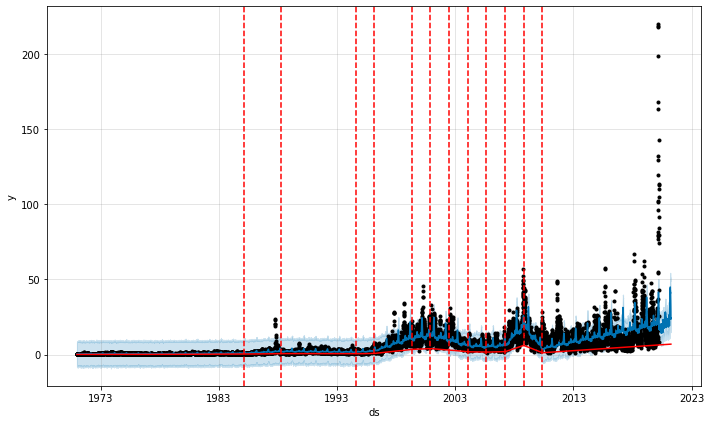

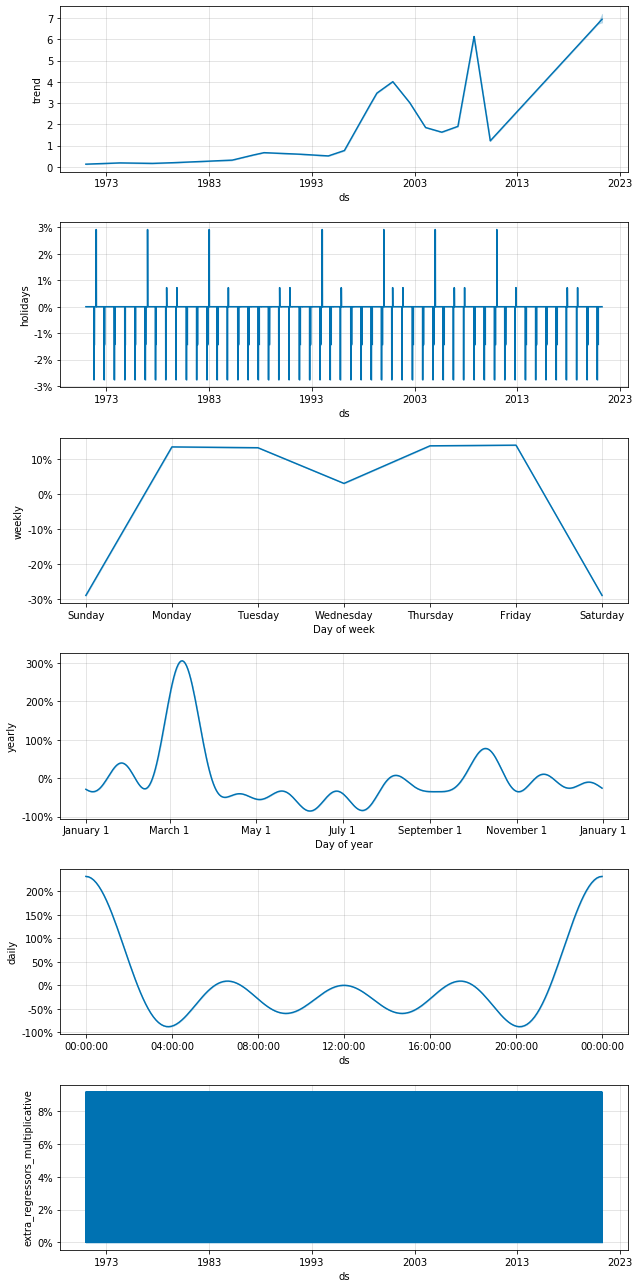

In [31]:
#Plot the fitted and forecasting results and turning points where the trends changed.
#Red dash lines indicate the turning points where the trends changed.
#Resources: https://facebook.github.io/prophet/docs/quick_start.html

fig = model.plot(fcast)
a = add_changepoints_to_plot(fig.gca(), model, fcast)
pyplot.show()

component = model.plot_components(fcast)
pyplot.show()

# Cross Validation

This techniques can be separately applied to any models mentioned above.

In [33]:
### Cross Validation using example of the begining model.
model = Prophet(daily_seasonality = True)
model.fit(df)

future = model.make_future_dataframe(periods = 365, freq = 'D')
fcast = model.predict(future)

In [34]:
### Cross-Validation: Check the performance of the model.
#Resources: Model Diagnostics>> https://facebook.github.io/prophet/docs/diagnostics.html
df_cv = cross_validation(model, initial = '11858 days', period = '365 days', horizon = '365 days') 
# The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat
# at each simulated forecast date and for each cutoff date.

#Performance metrics
df_p = performance_metrics(df_cv)
#print(df_p)

INFO:fbprophet:Making 16 forecasts with cutoffs between 2004-04-03 00:00:00 and 2019-03-31 00:00:00


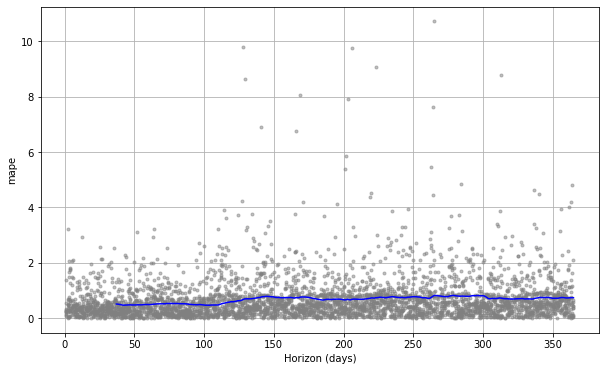

mape: 66.89%


In [35]:
fig_cv = plot_cross_validation_metric(df_cv, metric = 'mape') #Calculate time-series cross validation MAPE 
plt.show()

#Take the mean of mape we obtain from various computations via cross validation
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean())) 